## $\alpha \Omega$ Dynamo Equation using Crank Nicholson without Ghost Zones

This notebook will illustrate the crank nicholson difference method solving Galactic $\alpha \Omega$ Dynamo Equation.

## Crank-Nicolson Difference method

The implicit Crank-Nicolson difference equation of the Dynamo equation
is derived by discretising the following coupled equations

$$
\frac{\partial \bar{B}_r}{\partial t} = - \alpha \frac{\partial }{\partial z} (\bar{B}_{\phi}) + \frac{\partial^2 \bar{B}_r}{\partial z^2}
$$

$$
\frac{\partial \bar{B}_\phi}{\partial t} =  DS\bar{B}_r + \frac{\partial^2 \bar{B}_\phi}{\partial z^2} 
$$

Where $\alpha , D , S$ are currently constant parameters for this system.

**Discretization Scheme**

1. **Spatial Discretization**:

   We divide the spatial domain  $z$ into $N$ grid points. Let $h$ denote the spacing between consecutive grid points.

2. **Time Discretization**:

   We discretize the time domain $t$ into time steps of size $k$.

3. **Discretized Equations**:

   Using finite difference approximations, we discretize the time derivatives and the second-order spatial derivatives in the given PDEs.

   Let $B_i$ represent $B_r$ and $B_{N+i}$ represent $B_\phi$ for $i = 1, 2, \ldots, N$.

   The discretized equations for \( B_i \) and \( B_{N+i} \) are:

   - For $B_i$:
     $$
     \frac{B_i^{j+1} - B_i^{j}}{k} = -\alpha \frac{ ( B_{N+i+1}^{j+1} + B_{N+i+1}^{j} - B_{N+i-1}^{j+1} - B_{N+i-1}^{j} )}{4h} + \frac{1}{2} \left( \frac{B_{i-1}^{j+1} - 2B_{i}^{j+1} + B_{i+1}^{j+1} + B_{i-1}^{j} - 2B_{i}^{j} + B_{i+1}^{j}}{h^2} \right)
     $$

   - For $B_{N+i}$:
     $$
     \frac{B_{N+i}^{j+1} - B_{N+i}^{j}}{k} = DS \frac{(B_i^{j+1} + B_i^{j})}{2} + \frac{1}{2} \left( \frac{B_{N+i-1}^{j+1} - 2B_{N+i}^{j+1} + B_{N+i+1}^{j+1} + B_{N+i-1}^{j} - 2B_{N+i}^{j} + B_{N+i+1}^{j}}{h^2} \right)
     $$


In [1]:
# LIBRARY
# vector manipulation and matrix manipulation from external LIBRARY is allowed.
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend
from matplotlib import rcParams
from matplotlib.animation import FuncAnimation
from PIL import Image

# custom style parameters
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = '--'
rcParams['grid.alpha'] = 0.5

import warnings
warnings.filterwarnings("ignore")

## Discete Grid
The region $\Omega$ is discretised into a uniform mesh $\Omega_h$. In the space $x$ direction into $N$ steps giving a stepsize of

$$ h=\frac{1-0}{N} $$
resulting in 

$$ x[i]=0+ih, \ \ \  i=0,1,...,N, $$

and into $N_t$ steps in the time $t$ direction giving a stepsize of

$$ k=\frac{1-0}{N_t} $$
resulting in 

$$ t[i]=0+ik, \ \ \ k=0,...,K.$$
The Figure below shows the discrete grid points for $N=20$ and $N_t=400$ , the red dots are the unknown values, the green dots are the known boundary conditions and the blue dots are the known initial conditions of the Heat Equation.

In [2]:
N = 40
Nt = 400
h = 2 / N
k = 2 / Nt
r = k / (h * h)
time_steps = 20
time = np.arange(0, (time_steps + 0.5) * k, k)
z = np.arange(-1.001, 1.0001, h) 
Z, Y = np.meshgrid(z, time)

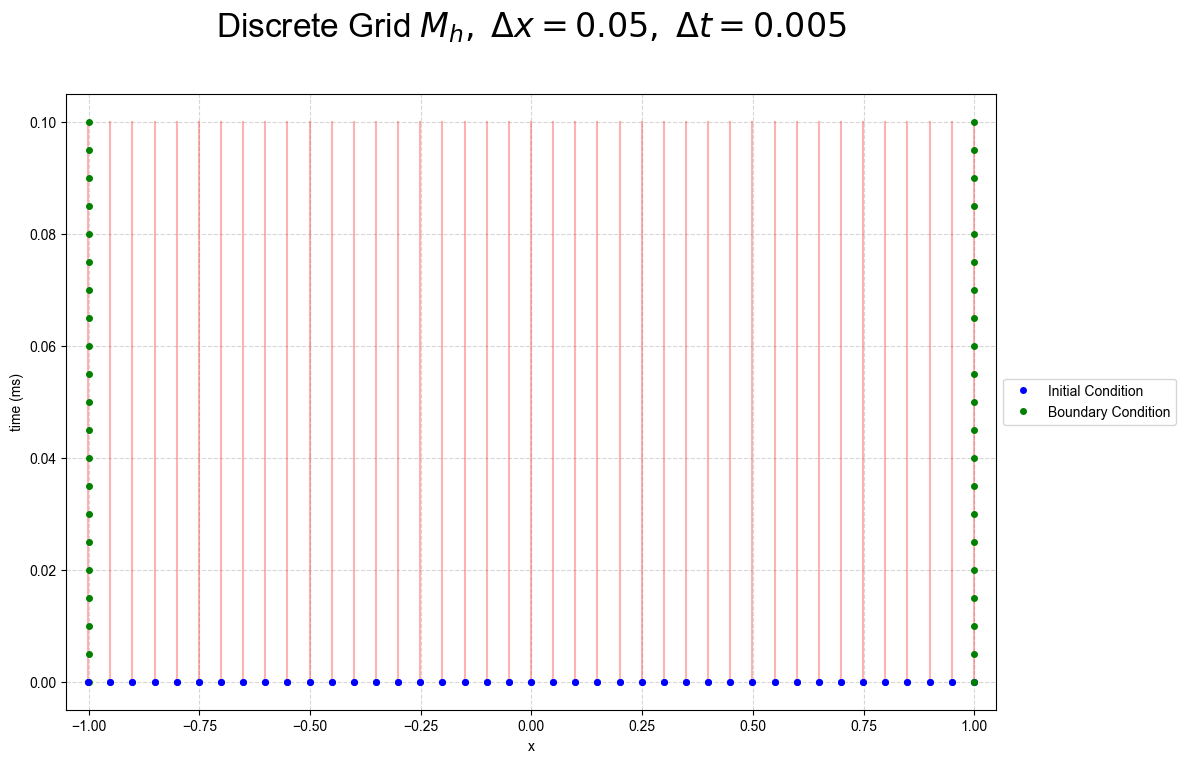

In [3]:
fig = plt.figure(figsize=(12, 8))
plt.plot(Z, Y, 'r-', alpha=0.3)  
plt.plot(z, 0 * z, 'bo', markersize=4, label='Initial Condition')  
plt.plot(np.ones(time_steps + 1) * -1, time, 'go', markersize=4, label='Boundary Condition')  
plt.plot(z, 0 * z, 'bo', markersize=4)
plt.plot(np.ones(time_steps + 1) * 1, time, 'go', markersize=4)
plt.xlim((-1.05, 1.05))  
plt.xlabel('x')
plt.ylabel('time (ms)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'Discrete Grid $M_h,$ $\Delta x= %s,$ $\Delta t=%s$' % (h, k), fontsize=24, y=1.08)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("results/grid.png")
plt.show()

## Initial and Boundary Conditions

### Vacuum Boundary Conditions

At $|z| = h$ for a disc-shaped magnetized system, continuity of magnetic field components requires $B_{\phi} = 0$ and $B_r \approx 0$ at $z = \pm h$. These exact conditions, known as *vacuum boundary conditions*, are due to axial symmetry and the outer magnetic field's potential structure.

### Discrete Initial and Boundary Conditions

Discrete initial conditions: $ B[i,0] = B_o \cos(\gamma z[i]) $.

Discrete boundary conditions: 

$$ B[0,j] = 0, \quad B[N,j] = 0 $$

Here, $B[i,j]$ represents the numerical approximation of $B(x[i],t[j])$. We employ the exact eigensolution for $B$ at $t=0$, ensuring physical accuracy. The figure below displays $B[i,0]$ for the initial (blue) and boundary (red) conditions at $t[0]=0$.


In [4]:
def generate_random_Bo(seed_value):
    np.random.seed(seed_value)  
    random_float = np.random.rand()  
    return random_float

def initial_conditions(N, time_steps, seed_value, m, n, BCtype = "vacuum"):
    mag_br = generate_random_Bo(seed_value)
    mag_bphi = generate_random_Bo(seed_value + 1)  
    
    z = np.linspace(-1, 1, N+1)
    Br = np.zeros((N+1, time_steps+1))
    Bphi = np.zeros((N+1, time_steps+1))
    b1 = np.zeros(N-1)
    b2 = np.zeros(N-1)
    
    # Initial Condition for Br and Bphi
    for i in range(1, N+1):
        Br[i, 0] = mag_br * np.cos((m + 1/2) * np.pi * z[i])
        Bphi[i, 0] = mag_bphi * np.cos((n + 1/2)* np.pi * z[i])
    
    # Boundary Condition
    if BCtype == "vacuum":
        Br[0, :] = 0
        Bphi[0, :] = 0
        Br[N, :] = 0
        Bphi[N, :] = 0

    return z, Br, Bphi, b1, b2, mag_br, mag_bphi

In [5]:
seed_value = 100
m, n = 3, 0
z, Br, Bphi, b1, b2, mag_br, mag_bphi = initial_conditions(N, time_steps, seed_value, m, n)

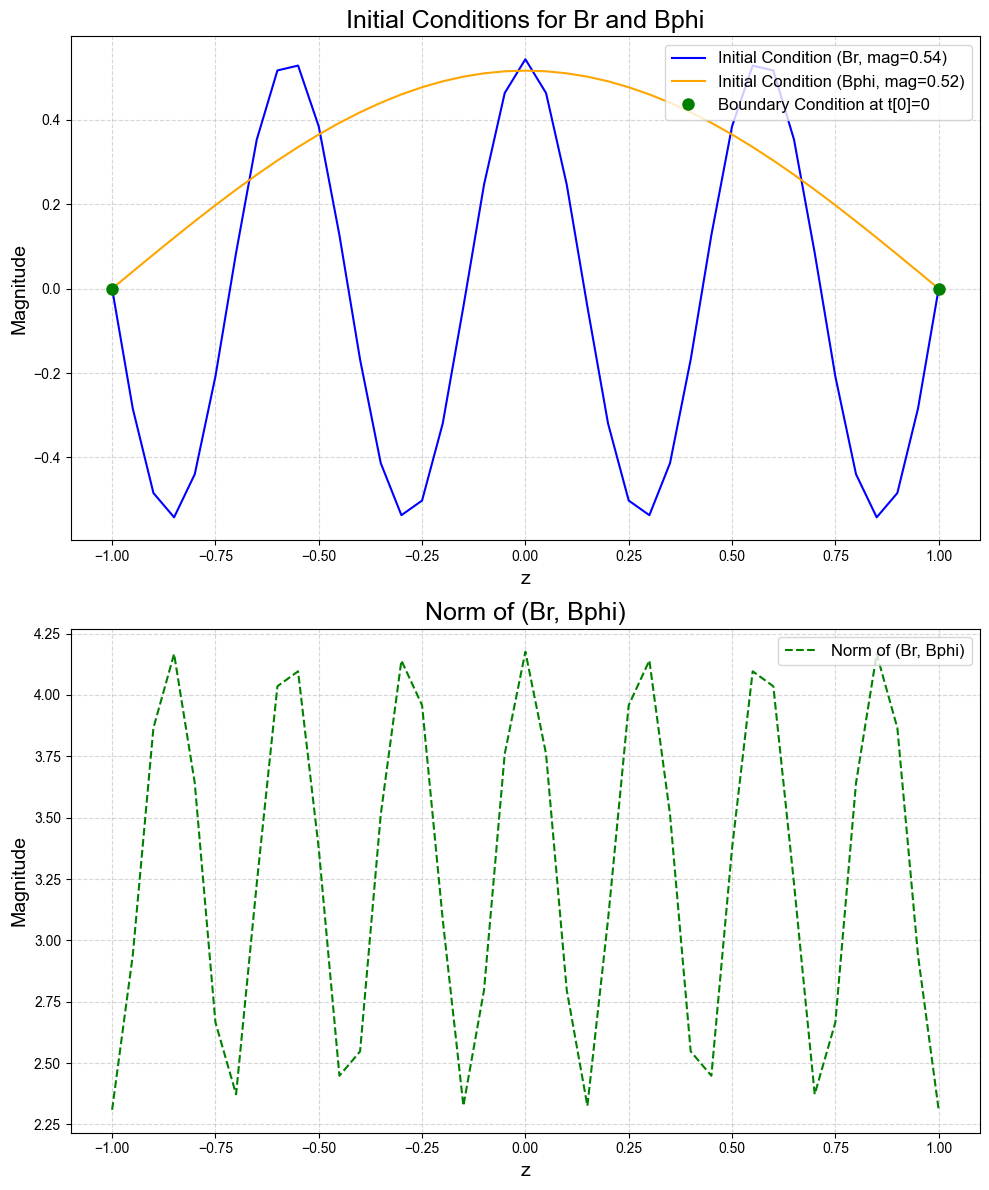

In [6]:
fig, axs = plt.subplots(2, figsize=(10, 12))

axs[0].plot(z, Br[:, 0], label=f'Initial Condition (Br, mag={mag_br:.2f})', color='blue')
axs[0].plot(z, Bphi[:,0], label=f'Initial Condition (Bphi, mag={mag_bphi:.2f})', color='orange')
axs[0].plot(z[[0, N]], Br[[0, N], 0], 'go', markersize=8, label='Boundary Condition at t[0]=0')
axs[0].set_title('Initial Conditions for Br and Bphi', fontsize=18)
axs[0].set_xlabel('z', fontsize=14)
axs[0].set_ylabel('Magnitude', fontsize=14)
axs[0].legend(loc='upper right', fontsize=12)
axs[0].grid(True, linestyle='--', alpha=0.5)


norm_Br_Bphi = [np.linalg.norm(np.sqrt(Br[i, 0]**2 + Bphi[:,0]**2)) for i in range(len(z))]
axs[1].plot(z, norm_Br_Bphi , label='Norm of (Br, Bphi)', linestyle='--', color='green')
axs[1].set_title('Norm of (Br, Bphi)', fontsize=18)
axs[1].set_xlabel('z', fontsize=14)
axs[1].set_ylabel('Magnitude', fontsize=14)
axs[1].legend(loc='upper right', fontsize=12)
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("results/initial_conditions.png")
plt.show()

## Matrix Representation

The discretized equations form a system of linear equations at each time step, which can be represented in matrix form $A \mathbf{x} = \mathbf{b}$, where $A$ is the coefficient matrix, $\mathbf{x}$ is the vector of unknowns at time $j+1$, and $\mathbf{b}$ is the vector containing terms at time $j$.

We could redefine a few parameters for the ease of this matrix representation. They are the following:

$$ \lambda = \frac{k}{2 h^2} $$

$$ \alpha = \frac{\alpha k}{4 h} $$

$$ \beta = \frac{DS k}{2} $$

After rearranging $j + 1$ terms on one side and $j$ terms on the other side of the equation, we get the following sets of linear equations:

$$ 
B_i^{j+1} (1 + 2 \lambda) - \lambda B_{i+1}^{j+1} - \lambda B_{i - 1}^{j+1} + \alpha B_{N+i+1}^{j+1} - \alpha B_{N+i - 1}^{j+1} = B_i^{j+1} (1 - 2 \lambda) + \lambda B_{i+1}^{j+1} + \lambda B_{i - 1}^{j+1} - \alpha B_{N+i+1}^{j+1} + \alpha B_{N+i - 1}^{j+1}
$$

$$ 
B_i^{j+1} (1 + 2 \lambda) - \lambda B_{i+1}^{j+1} - \lambda B_{i - 1}^{j+1} - \beta B_{i}^{j+1} = B_i^{j+1} (1 - 2 \lambda) + \lambda B_{i+1}^{j+1} + \lambda B_{i - 1}^{j+1} + \beta B_{i+1}^{j+1} 
$$

Combining these two expressions as one $2N$ vector transformation, i.e., $B_i^{j}$ where $i = 1, 2, 3, \ldots, 2N$ or $\mathbf{B} = (B_r, B_{\phi})^T$, we can represent the matrix equation as:

$$
T \mathbf{B}_{j+1} = S \mathbf{B}_{j} + \mathbf{b}_{j} + \mathbf{b}_{j+1}
$$

Here, $T$ and $S$ are evolution matrices for the system, and $\mathbf{b}_j$ and $\mathbf{b}_{j+1}$ are column vectors representing the boundary conditions for the current and next time steps, respectively.

*Detailed calculations are available in the PDF [here](link).*

In [7]:
# parameters of differential equation
Ro = 20
ho = 1
alpha0 = 10
omega0 = 10
etat = 1
r = 18
q = 1 # for flat rotation discs

def linear_parameters(r):
    D0 = q*alpha0*omega0*(Ro/r)*h**3/etat**2
    alpha = alpha0 * Ro/r
    S = - omega0 * Ro/r
    D = - D0 * Ro/r
    
    # parameters of linear equation
    l = k/(2*h**2)
    a = alpha * k/(4*h)
    b = D*S*k/2
    
    return l, a, b, D

### Finding the Critical Dynamo Number by Varying $r$ as $D$ is Inversely Proportional to $r^2$

Finding the critical dynamo number involves a systematic exploration of how the magnetic diffusion coefficient $D$ influences the behavior of the magnetic field in a simulated system. One common approach is to vary $D$ indirectly by adjusting a related parameter, such as the radius ($r$) of the system. Since $D$ is inversely proportional to $r^2$, increasing the radius decreases $D$, and vice versa.

#### Steps to Determine the Critical Dynamo Number:

1. **Parameter Variation:**
   - Vary the radius $r$ of the system while keeping other parameters constant. This effectively changes the magnetic diffusion coefficient $D$.

2. **Simulation Runs:**
   - Perform simulations of the system for each value of $r$.
   - In each simulation, solve the coupled partial differential equations governing the evolution of the magnetic field components $B_r$ and $B_\phi$ numerically over time.

3. **Observation of Behavior:**
   - Observe how the magnetic field evolves over time for each value of $r$.
   - Pay attention to whether the magnetic field undergoes exponential growth, decay, or remains stable.

4. **Identification of Critical Dynamo Number:**
   - Analyze the simulations to identify the smallest radius (or largest $D$ for which the magnetic field exhibits exponential growth.
   - This radius (or corresponding $D$ value) is considered the critical dynamo number for the system.

5. **Validation and Refinement:**
   - Validate the identified critical dynamo number through further simulations or sensitivity analyses.
   - Refine the determination if necessary by adjusting simulation parameters or exploring additional parameter variations.

In [8]:
bc1 = np.concatenate((b1, b2))
B1 = np.concatenate((Br, Bphi))

def dynamo_numbers(r, B, bc):
    # linear parameters
    l, a, b, D = linear_parameters(r)
    
    #  T and S
    T = np.zeros((2*N-2, 2*N-2))
    S = np.zeros((2*N-2, 2*N-2))
    for i in range(2*N-2):
        T[i, i] = 2 + 2 * l
        S[i, i] = 2 - 2 * l
        if i < 2*N-4:
            T[i, i+1] = -l
            T[i+1, i] = -l
            S[i, i+1] = l
            S[i+1, i] = l
        if i < N-2:
            T[i, N + i] = a
            S[i, N +i] = -a 
            if i != 0:
                T[i, N +i -2] = -a
                S[i, N + i -2] = a
            S[N+i, i] = -b
            T[N + i, i] = b
        if i == N-2:
            T[i, N + i - 2] = -a
            S[i, N + i - 2] = a

    # inverse of T
    T_inv = np.linalg.inv(T)
    
    for j in range (1,time_steps+1):
        bc[0]=l*B[0,j-1]+l*B[0,j]
        bc[N-2]=l*B[N,j-1]+l*B[N,j]
        bc[N-1]= l*B[N+1,j-1]+l*B[N+1,j]
        bc[2*N-4]=l*B[2*N,j-1]+l*B[2*N,j]
        v1=np.dot(S,B[1:(2*N -1),j-1])
        B[1:(2*N -1),j]=np.dot(T_inv,v1+bc)
        
    Br0 = B[0:N+1, :]
    Bphi0 = B[N+1:2*N+2, :]
    
    return Br0, Bphi0, l, a, b, D

def critical_dynamo_numbers(Ro, num_points, B, bc, num_time_indices):
    r_values = np.linspace(0.001, Ro, num_points)[::-1]  
    for r in r_values:
        Br, Bphi, l, a, b, D = dynamo_numbers(r, B, bc)
        B_combined = np.concatenate((Br, Bphi), axis=0)  
        # Checks if the magnitude of B values grows over all time indices
        B_norm_prev = np.linalg.norm(B_combined[:, 0])  
        increasing = True
        for i in range(1, num_time_indices):
            B_norm_current = np.linalg.norm(B_combined[:, i])
            if B_norm_current <= B_norm_prev:
                increasing = False
                break
            B_norm_prev = B_norm_current
        
        if increasing:
            print(f"At r = {r}, B values start increasing with time for all time indices.")
            print(f"Linear Parameters: l = {l}, a = {a}, b = {b}, D = {D}")
            return r, l, a, b, D


In [9]:
Ro = 20  
num_points = 200  
num_time_indices = 20  
critical_r, l, a, b, D = critical_dynamo_numbers(Ro, num_points, B1, bc1, num_time_indices)

At r = 1.8099547738693464, B values start increasing with time for all time indices.
Linear Parameters: l = 0.9999999999999998, a = 2.762499965295227, b = 0.421635179421727, D = -1.5262812116512265


## Results above critical Dynamo number

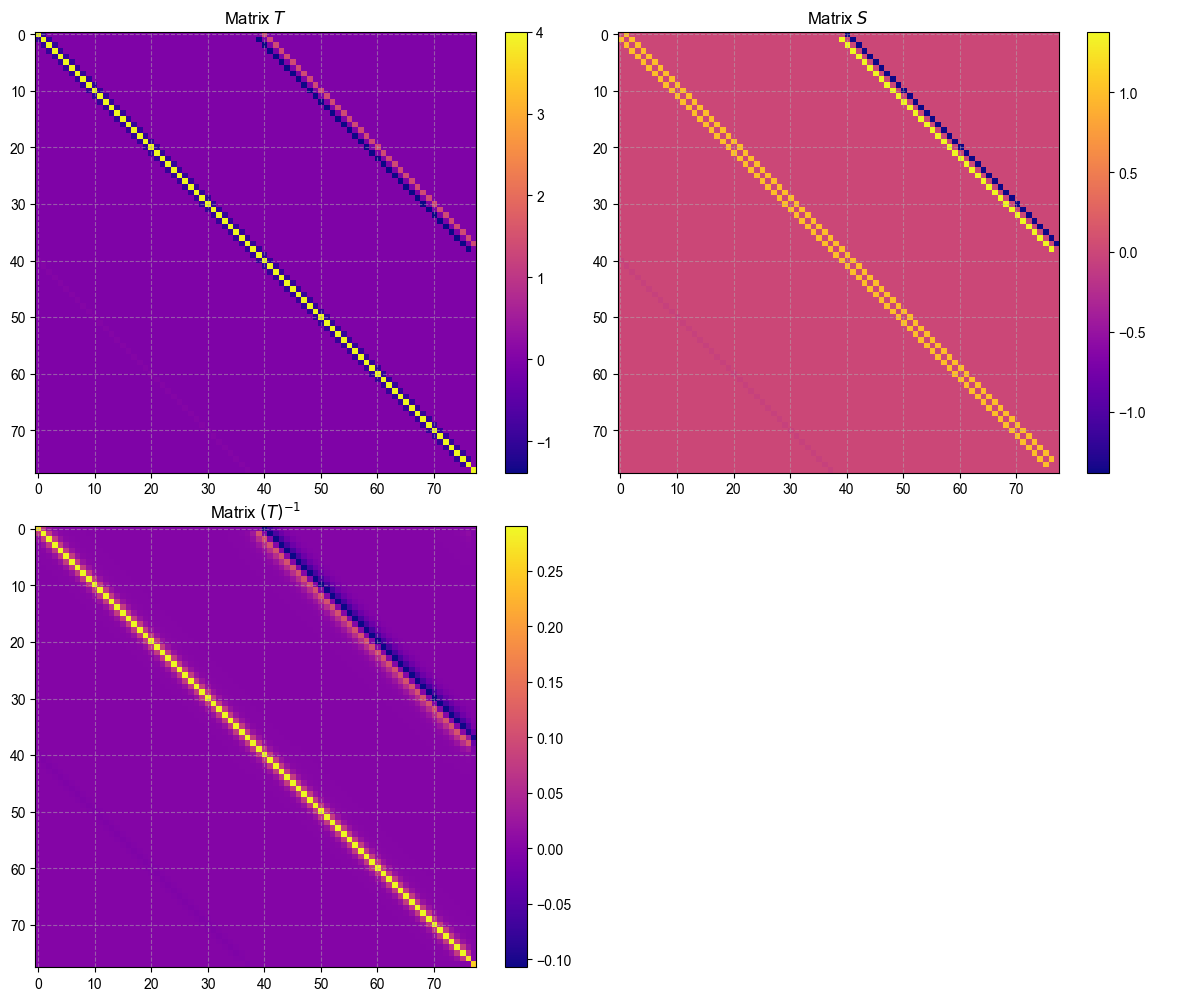

In [10]:
l, a, b, D = linear_parameters(critical_r)

#  A and B
T = np.zeros((2*N-2, 2*N-2))
S = np.zeros((2*N-2, 2*N-2))
for i in range(2*N-2):
    T[i, i] = 2 + 2 * l
    S[i, i] = 2 - 2 * l
    if i < 2*N-4:
        T[i, i+1] = -l
        T[i+1, i] = -l
        S[i, i+1] = l
        S[i+1, i] = l
        if i < N-2:
            T[i, N + i] = a
            S[i, N +i] = -a 
            if i != 0:
                T[i, N +i -2] = -a
                S[i, N + i -2] = a
            S[N+i, i] = -b
            T[N + i, i] = b
        if i == N-2:
            T[i, N + i - 2] = -a
            S[i, N + i - 2] = a

# inverse of T
T_inv = np.linalg.inv(T)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
im = axs[0, 0].imshow(T, cmap='plasma')
axs[0, 0].set_title(r'Matrix $T$')
plt.colorbar(im, ax=axs[0, 0])
im = axs[0, 1].imshow(S, cmap='plasma')
axs[0, 1].set_title(r'Matrix $S$')
plt.colorbar(im, ax=axs[0, 1])
im = axs[1, 0].imshow(T_inv, cmap='plasma')
axs[1, 0].set_title(r'Matrix $(T)^{-1}$')
plt.colorbar(im, ax=axs[1, 0])
axs[1, 1].axis('off')

plt.tight_layout()
plt.savefig("results/matrix_T_S_T_inv_above_critical_dynamo.png")
plt.show()

In [11]:
bc = np.concatenate((b1, b2))
B = np.concatenate((Br, Bphi))
for j in range (1,time_steps+1):
    bc[0]=l*B[0,j-1]+l*B[0,j]
    bc[N-2]=l*B[N,j-1]+l*B[N,j]
    bc[N-1]= l*B[N+1,j-1]+l*B[N+1,j]
    bc[2*N-4]=l*B[2*N,j-1]+l*B[2*N,j]
    v1=np.dot(S,B[1:(2*N -1),j-1])
    B[1:(2*N -1),j]=np.dot(T_inv,v1+bc)

In [12]:
Br = B[0:N+1, :]
Bphi = B[N+1:2*N+2, :]

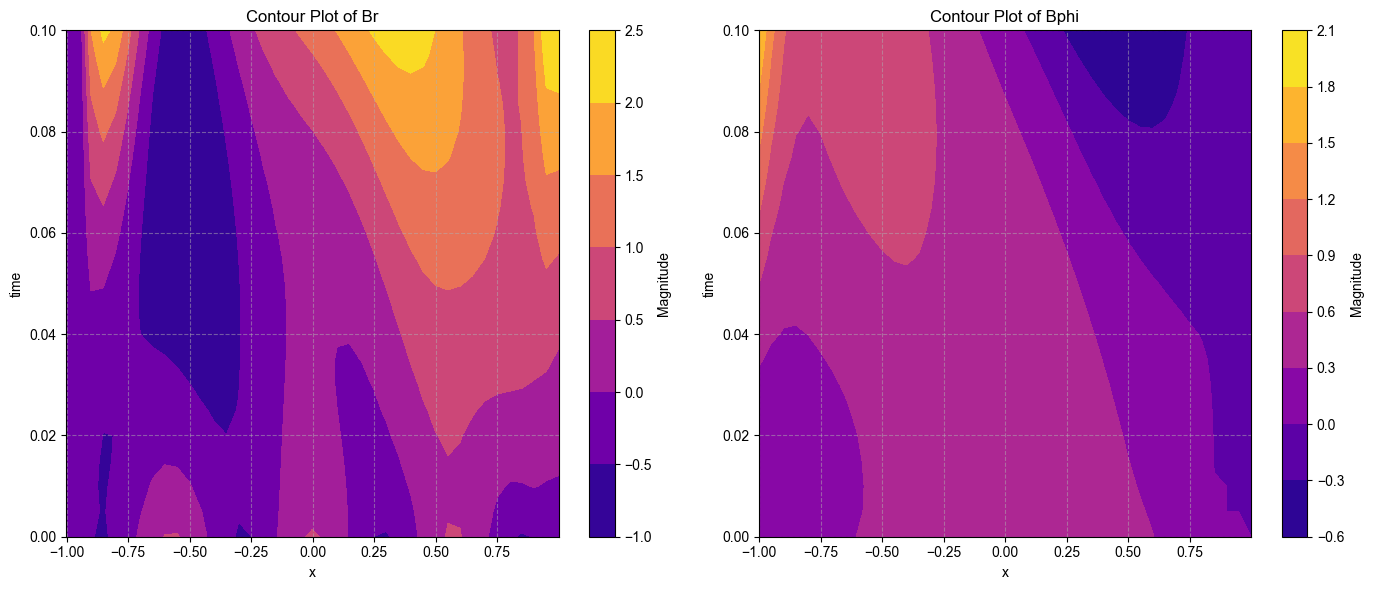

In [13]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.contourf(Z, Y, Br.transpose(), cmap='plasma')
plt.colorbar(label='Magnitude')
#plt.ylim((0, 0.005))
plt.xlabel('x')
plt.ylabel('time')
plt.title('Contour Plot of Br')

plt.subplot(1, 2, 2)
plt.contourf(Z, Y, Bphi.transpose(), cmap='plasma')
plt.colorbar(label='Magnitude')
#plt.ylim((0, 0.005))
plt.xlabel('x')
plt.ylabel('time')
plt.title('Contour Plot of Bphi')

plt.tight_layout()
plt.savefig("results/contour_plot_Br_Bphi_above_critical_D.png")
plt.show()

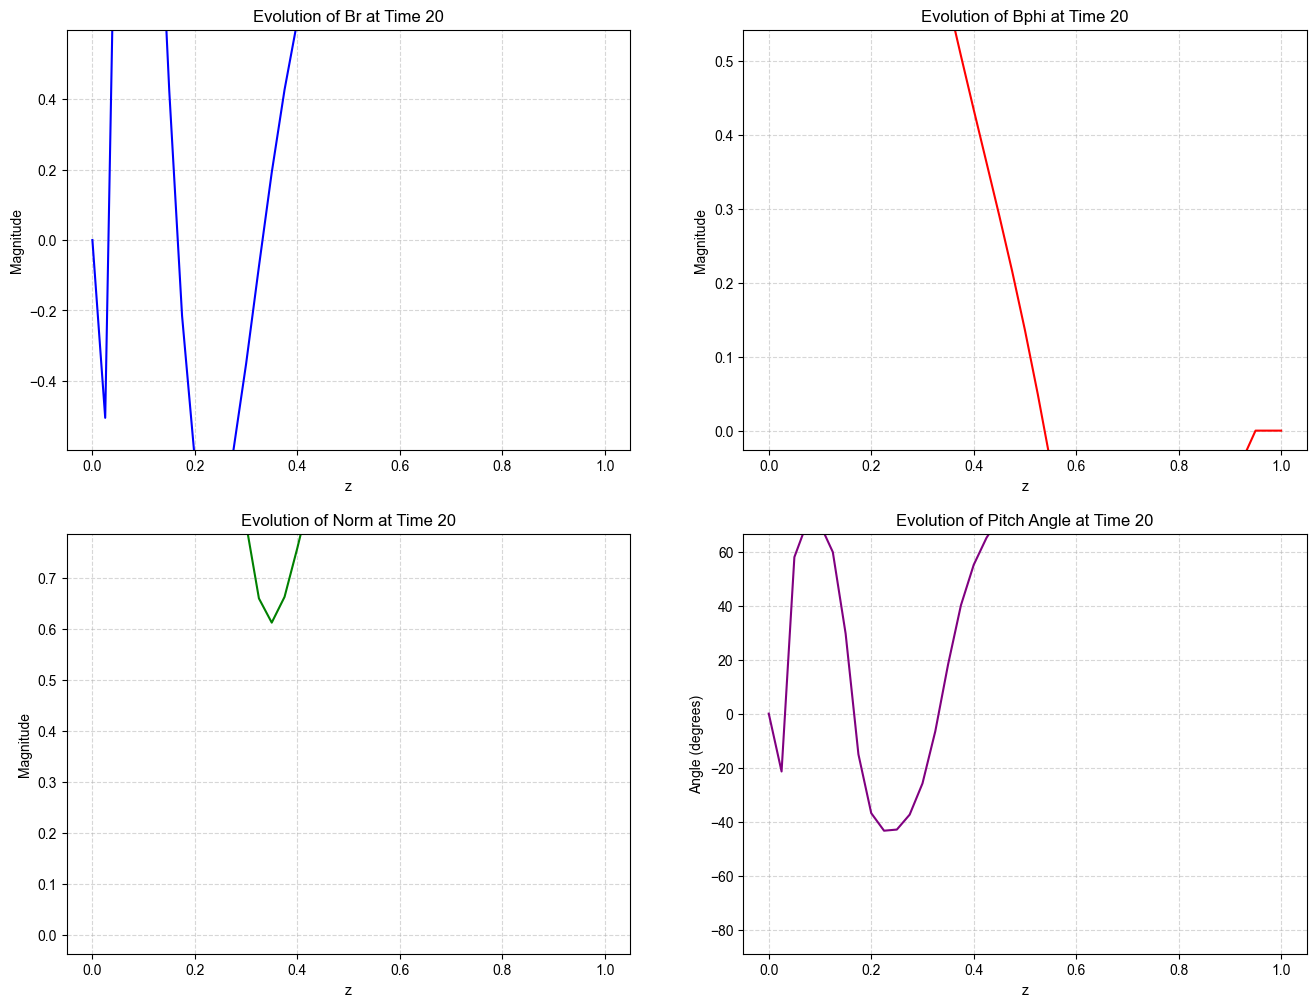

In [14]:
norm_squared_sum = np.sqrt(Br**2 + Bphi**2)
pitch_angle = np.arctan2(Br, Bphi) * (180 / np.pi)

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
# Plot Br
line_br, = axs[0, 0].plot(np.linspace(0, 1, Br.shape[0]), Br[:, 0], color='blue', label='Br')
axs[0, 0].set_xlabel('z')
axs[0, 0].set_ylabel('Magnitude')
axs[0, 0].set_title('Evolution of Br')

# Plot Bphi
line_bphi, = axs[0, 1].plot(np.linspace(0, 1, Bphi.shape[0]), Bphi[:, 0], color='red', label='Bphi')
axs[0, 1].set_xlabel('z')
axs[0, 1].set_ylabel('Magnitude')
axs[0, 1].set_title('Evolution of Bphi')

# Plot Norm
line_norm, = axs[1, 0].plot(np.linspace(0, 1, norm_squared_sum.shape[0]), norm_squared_sum[:, 0], color='green', label='Norm')
axs[1, 0].set_xlabel('z')
axs[1, 0].set_ylabel('Magnitude')
axs[1, 0].set_title('Evolution of Norm')


line_pitch, = axs[1, 1].plot(np.linspace(0, 1, pitch_angle.shape[0]), pitch_angle[:, 0], color='purple', label='Pitch Angle')
axs[1, 1].set_xlabel('z')
axs[1, 1].set_ylabel('Angle (degrees)')
axs[1, 1].set_title('Evolution of Pitch Angle')

def update(frame):
    line_br.set_ydata(Br[:, frame])
    axs[0, 0].set_title(f'Evolution of Br at Time {frame}')
    
    line_bphi.set_ydata(Bphi[:, frame])
    axs[0, 1].set_title(f'Evolution of Bphi at Time {frame}')
    
    line_norm.set_ydata(norm_squared_sum[:, frame])
    axs[1, 0].set_title(f'Evolution of Norm at Time {frame}')
    
    line_pitch.set_ydata(pitch_angle[:, frame])
    axs[1, 1].set_title(f'Evolution of Pitch Angle at Time {frame}')
    
    return line_br, line_bphi, line_norm, line_pitch

ani = FuncAnimation(fig, update, frames=range(Br.shape[1]), interval=100)
ani.save('results/Br_Bphi_Norm_Pitch_evolution_above_critical_D.gif', writer='pillow')

plt.show()

In [15]:
log_Br = np.log(Br[18])
log_Bphi = np.log(Bphi[18])

In [16]:
slope_Br_1, intercept_Br_1 = np.polyfit(time[:8], log_Br[:8], 1)
slope_Bphi_1, intercept_Bphi_1= np.polyfit(time[4:12], log_Bphi[4:12], 1)

slope_Br_2, intercept_Br_2 = np.polyfit(time[10:], log_Br[10:], 1)
slope_Bphi_2, intercept_Bphi_2 = np.polyfit(time[8:], log_Bphi[8:], 1)

actual_slope_Br = (m + 1/2)* np.pi  
actual_slope_Bphi = (n + 1/2)* np.pi

difference_Br_1 = np.sqrt(-slope_Br_1) - actual_slope_Br
difference_Bphi_1 = np.sqrt(slope_Bphi_1) - actual_slope_Bphi

difference_Br_2 = np.sqrt(slope_Br_2) - actual_slope_Br
difference_Bphi_2 = np.sqrt(-slope_Bphi_2) - actual_slope_Bphi

print(f"Br: Actual Slope 1 = {actual_slope_Br}, Computed Slope 1 = {np.sqrt(-slope_Br_1)}, Difference 1 = {difference_Br_1}")
print(f"Bphi: Actual Slope 1 = {actual_slope_Bphi}, Computed Slope 1 = {np.sqrt(slope_Bphi_1)}, Difference 1 = {difference_Bphi_1}")
print(f"Br: Actual Slope 2 = {actual_slope_Br}, Computed Slope 2 = {np.sqrt(slope_Br_2)}, Difference 2 = {difference_Br_2}")
print(f"Bphi: Actual Slope 2 = {actual_slope_Bphi}, Computed Slope 2 = {np.sqrt(-slope_Bphi_2)}, Difference 2 = {difference_Bphi_2}")

Br: Actual Slope 1 = 10.995574287564276, Computed Slope 1 = 8.719215778839475, Difference 1 = -2.276358508724801
Bphi: Actual Slope 1 = 1.5707963267948966, Computed Slope 1 = 1.132210564091371, Difference 1 = -0.43858576270352545
Br: Actual Slope 2 = 10.995574287564276, Computed Slope 2 = 8.675716247130113, Difference 2 = -2.3198580404341627
Bphi: Actual Slope 2 = 1.5707963267948966, Computed Slope 2 = 2.6600356021997467, Difference 2 = 1.08923927540485


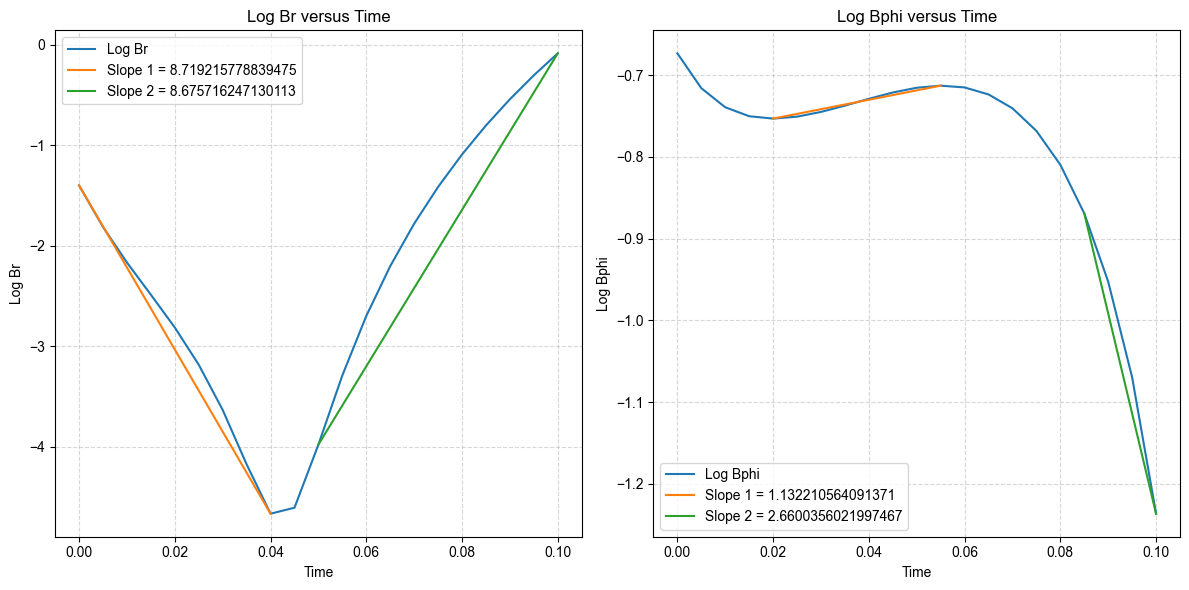

In [17]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(time, log_Br, label=f"Log Br")  # Plot the curve for Log Br
plt.plot([time[0], time[8]], [log_Br[0], log_Br[8]], linestyle='-', label=f"Slope 1 = {np.sqrt(-slope_Br_1)}") 
plt.plot([time[10], time[-1]], [log_Br[10], log_Br[-1]], linestyle='-', label=f"Slope 2 = {np.sqrt(slope_Br_2)}") 
plt.xlabel('Time')
plt.ylabel('Log Br')
plt.title('Log Br versus Time')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time, log_Bphi, label='Log Bphi') 
plt.plot([time[4], time[11]], [log_Bphi[4], log_Bphi[11]], linestyle='-', label=f"Slope 1 = {np.sqrt(slope_Bphi_1)}") 
plt.plot([time[17], time[-1]], [log_Bphi[17], log_Bphi[-1]], linestyle='-', label=f"Slope 2 = {np.sqrt(-slope_Bphi_2)}")  
plt.xlabel('Time')
plt.ylabel('Log Bphi')
plt.title('Log Bphi versus Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("results/log_Br_Bphi_vs_time_above_critical_D.png")
plt.show()

|       | Actual Slope | Computed Slope | Difference |
|-------|--------------|----------------|------------|
| Br 1  | 10.9956      | 8.7201         | -2.2755    |
| Bphi 1| 1.5708       | 1.1325         | -0.4383    |
| Br 2  | 10.9956      | 8.6488         | -2.3467    |
| Bphi 2| 1.5708       | 2.6475         | 1.0767     |

## Results Below Critical Dynamo Number

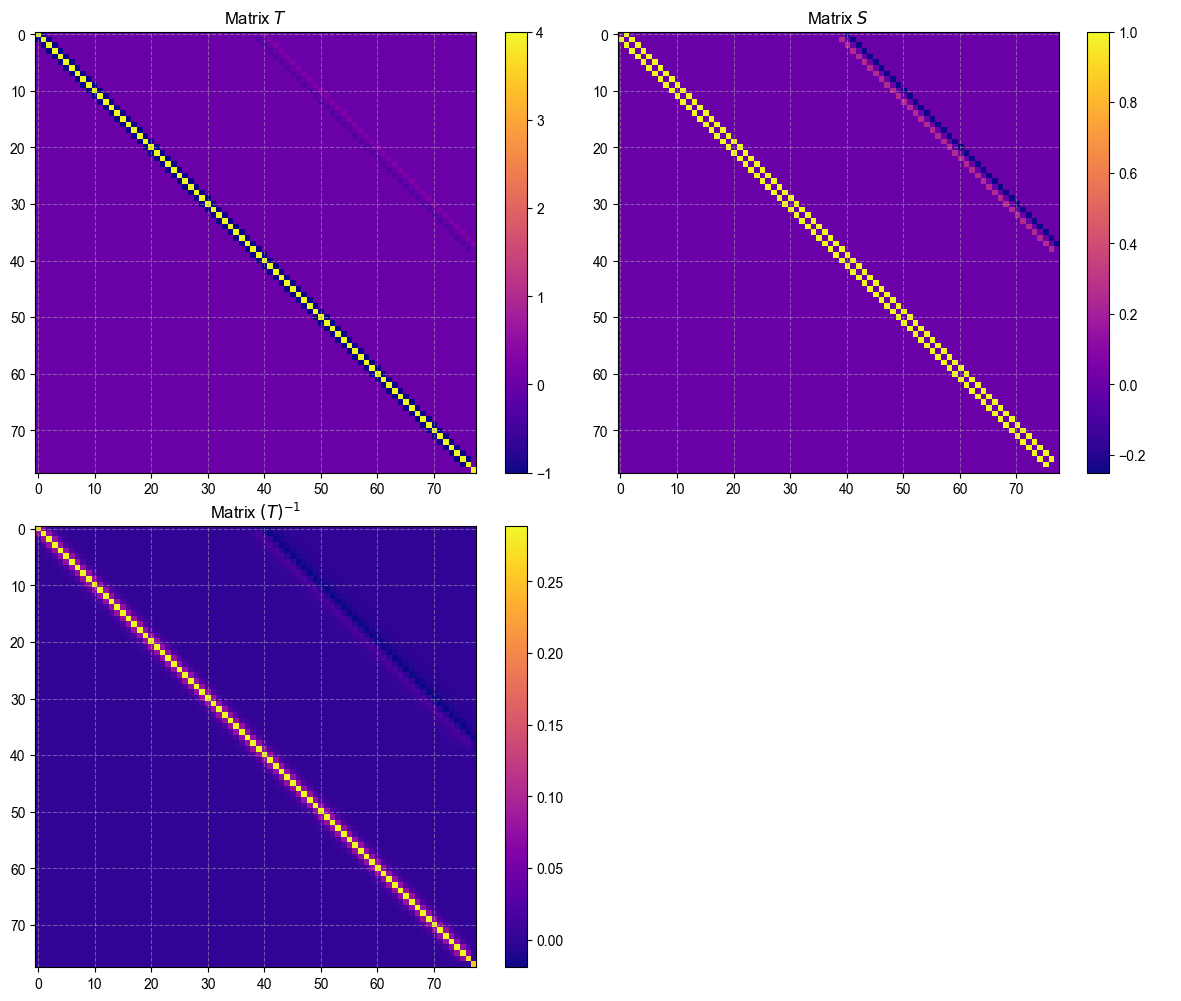

In [18]:
l, a, b, D = linear_parameters(critical_r - 10*h)

#  A and B
T = np.zeros((2*N-2, 2*N-2))
S = np.zeros((2*N-2, 2*N-2))
for i in range(2*N-2):
    T[i, i] = 2 + 2 * l
    S[i, i] = 2 - 2 * l
    if i < 2*N-4:
        T[i, i+1] = -l
        T[i+1, i] = -l
        S[i, i+1] = l
        S[i+1, i] = l
        if i < N-2:
            T[i, N + i] = a
            S[i, N +i] = -a 
            if i != 0:
                T[i, N +i -2] = -a
                S[i, N + i -2] = a
            S[N+i, i] = -b
            T[N + i, i] = b
        if i == N-2:
            T[i, N + i - 2] = -a
            S[i, N + i - 2] = a

# inverse of T
T_inv = np.linalg.inv(T)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
im = axs[0, 0].imshow(T, cmap='plasma')
axs[0, 0].set_title(r'Matrix $T$')
plt.colorbar(im, ax=axs[0, 0])
im = axs[0, 1].imshow(S, cmap='plasma')
axs[0, 1].set_title(r'Matrix $S$')
plt.colorbar(im, ax=axs[0, 1])
im = axs[1, 0].imshow(T_inv, cmap='plasma')
axs[1, 0].set_title(r'Matrix $(T)^{-1}$')
plt.colorbar(im, ax=axs[1, 0])
axs[1, 1].axis('off')

plt.tight_layout()
plt.savefig("results/matrix_T_S_T_inv_below_critical_dynamo.png")
plt.show()

In [19]:
bc = np.concatenate((b1, b2))
B = np.concatenate((Br, Bphi))
for j in range (1,time_steps+1):
    bc[0]=l*B[0,j-1]+l*B[0,j]
    bc[N-2]=l*B[N,j-1]+l*B[N,j]
    bc[N-1]= l*B[N+1,j-1]+l*B[N+1,j]
    bc[2*N-4]=l*B[2*N,j-1]+l*B[2*N,j]
    v1=np.dot(S,B[1:(2*N -1),j-1])
    B[1:(2*N -1),j]=np.dot(T_inv,v1+bc)

In [20]:
Br = B[0:N+1, :]
Bphi = B[N+1:2*N+2, :]

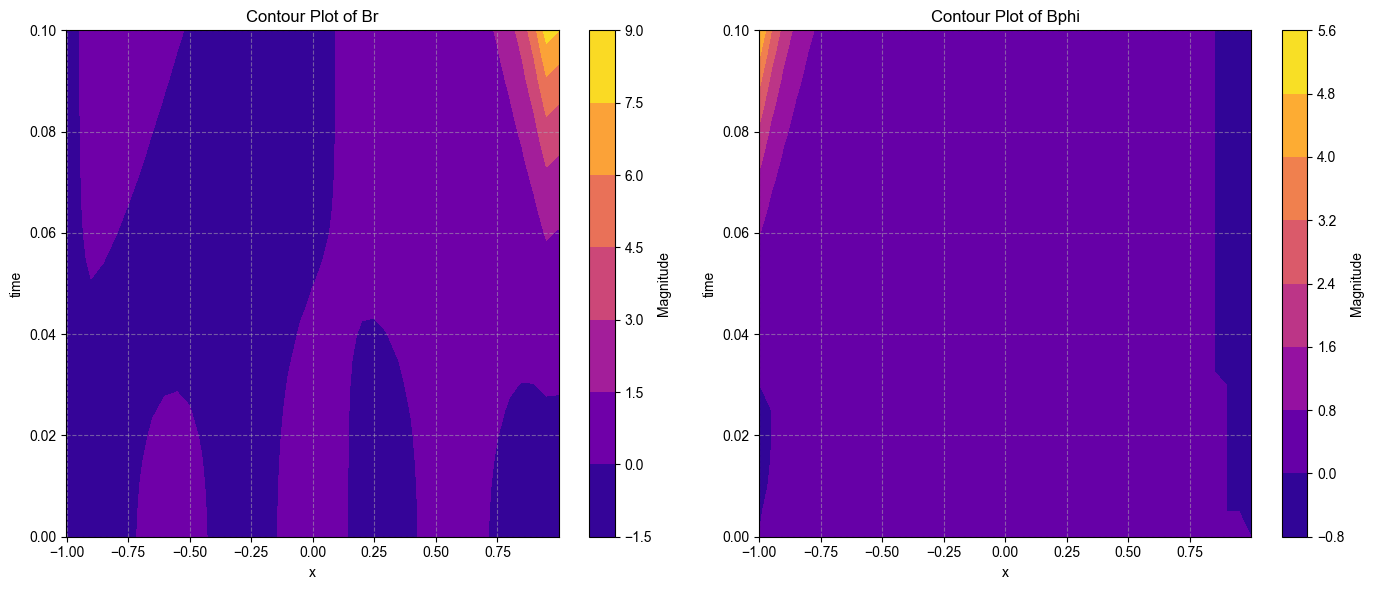

In [21]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.contourf(Z, Y, Br.transpose(), cmap='plasma')
plt.colorbar(label='Magnitude')
#plt.ylim((0, 0.005))
plt.xlabel('x')
plt.ylabel('time')
plt.title('Contour Plot of Br')

plt.subplot(1, 2, 2)
plt.contourf(Z, Y, Bphi.transpose(), cmap='plasma')
plt.colorbar(label='Magnitude')
#plt.ylim((0, 0.005))
plt.xlabel('x')
plt.ylabel('time')
plt.title('Contour Plot of Bphi')

plt.tight_layout()
plt.savefig("results/contour_plot_Br_Bphi_below_critical_D.png")
plt.show()

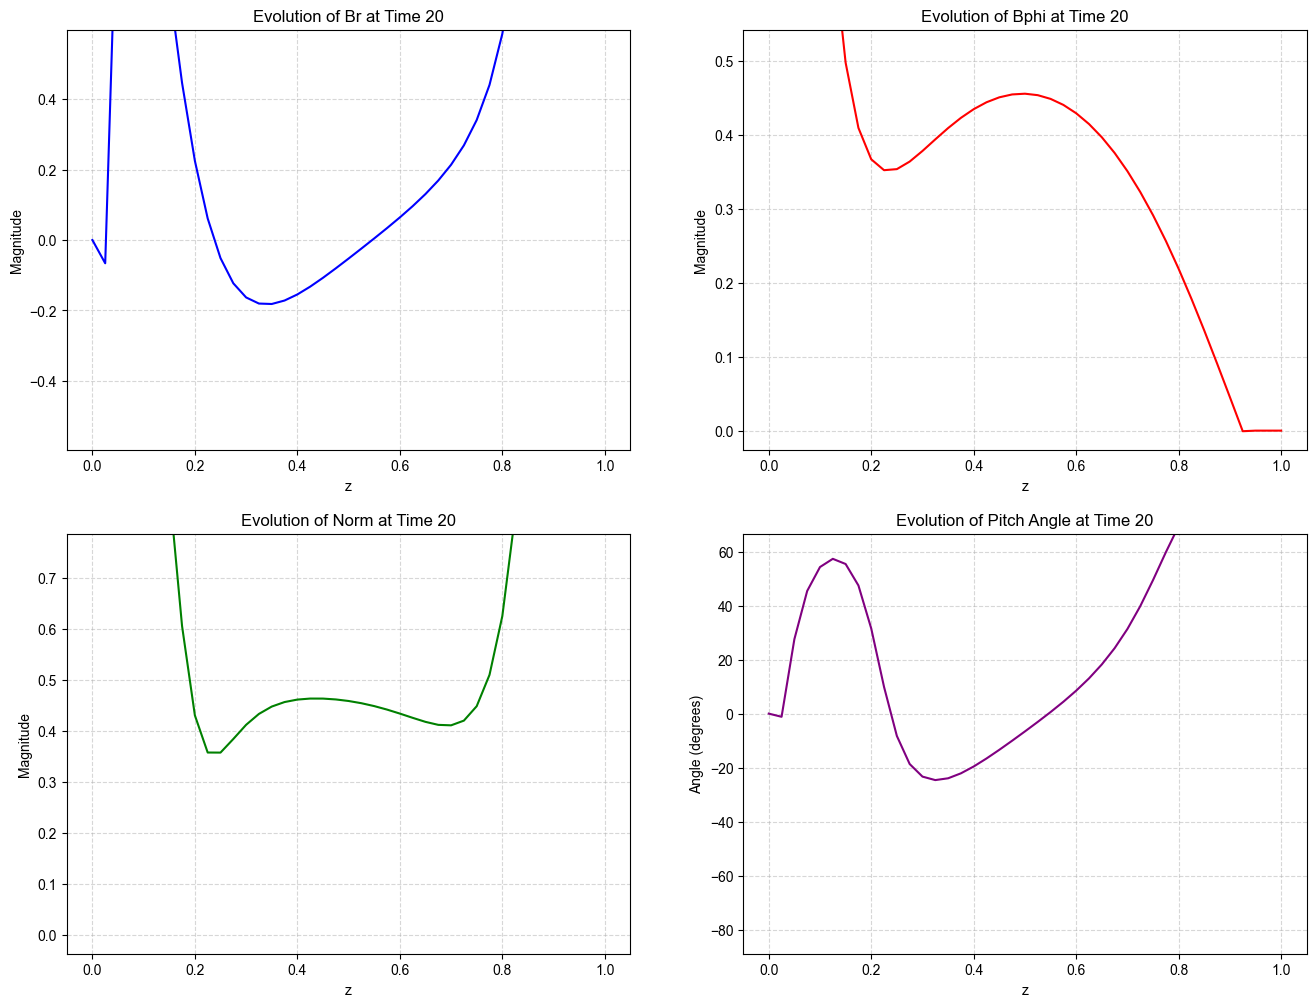

In [22]:
norm_squared_sum = np.sqrt(Br**2 + Bphi**2)
pitch_angle = np.arctan2(Br, Bphi) * (180 / np.pi)

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
# Plot Br
line_br, = axs[0, 0].plot(np.linspace(0, 1, Br.shape[0]), Br[:, 0], color='blue', label='Br')
axs[0, 0].set_xlabel('z')
axs[0, 0].set_ylabel('Magnitude')
axs[0, 0].set_title('Evolution of Br')

# Plot Bphi
line_bphi, = axs[0, 1].plot(np.linspace(0, 1, Bphi.shape[0]), Bphi[:, 0], color='red', label='Bphi')
axs[0, 1].set_xlabel('z')
axs[0, 1].set_ylabel('Magnitude')
axs[0, 1].set_title('Evolution of Bphi')

# Plot Norm
line_norm, = axs[1, 0].plot(np.linspace(0, 1, norm_squared_sum.shape[0]), norm_squared_sum[:, 0], color='green', label='Norm')
axs[1, 0].set_xlabel('z')
axs[1, 0].set_ylabel('Magnitude')
axs[1, 0].set_title('Evolution of Norm')


line_pitch, = axs[1, 1].plot(np.linspace(0, 1, pitch_angle.shape[0]), pitch_angle[:, 0], color='purple', label='Pitch Angle')
axs[1, 1].set_xlabel('z')
axs[1, 1].set_ylabel('Angle (degrees)')
axs[1, 1].set_title('Evolution of Pitch Angle')

def update(frame):
    line_br.set_ydata(Br[:, frame])
    axs[0, 0].set_title(f'Evolution of Br at Time {frame}')
    
    line_bphi.set_ydata(Bphi[:, frame])
    axs[0, 1].set_title(f'Evolution of Bphi at Time {frame}')
    
    line_norm.set_ydata(norm_squared_sum[:, frame])
    axs[1, 0].set_title(f'Evolution of Norm at Time {frame}')
    
    line_pitch.set_ydata(pitch_angle[:, frame])
    axs[1, 1].set_title(f'Evolution of Pitch Angle at Time {frame}')
    
    return line_br, line_bphi, line_norm, line_pitch

ani = FuncAnimation(fig, update, frames=range(Br.shape[1]), interval=100)
ani.save('results/Br_Bphi_Norm_Pitch_evolution_below_critical_D.gif', writer='pillow')

plt.show()

In [23]:
log_Br = np.log(Br[21][:12])
log_Bphi = np.log(Bphi[10][:12])

In [24]:
slope_Br, intercept_Br = np.polyfit(time[:12], log_Br, 1)
slope_Bphi, intercept_Bphi = np.polyfit(time[:12], log_Bphi, 1)

actual_slope_Br = (m + 1/2)* np.pi  
actual_slope_Bphi = (n + 1/2)* np.pi

difference_Br = np.sqrt(-slope_Br) - actual_slope_Br
difference_Bphi = np.sqrt(-slope_Bphi) - actual_slope_Bphi

print(f"Br: Actual Slope = {actual_slope_Br}, Computed Slope = {np.sqrt(-slope_Br)}, Difference = {difference_Br}")
print(f"Bphi: Actual Slope = {actual_slope_Bphi}, Computed Slope = {np.sqrt(-slope_Bphi)}, Difference = {difference_Bphi}")

Br: Actual Slope = 10.995574287564276, Computed Slope = 9.418525678804562, Difference = -1.5770486087597142
Bphi: Actual Slope = 1.5707963267948966, Computed Slope = 1.1290958367090955, Difference = -0.44170049008580103


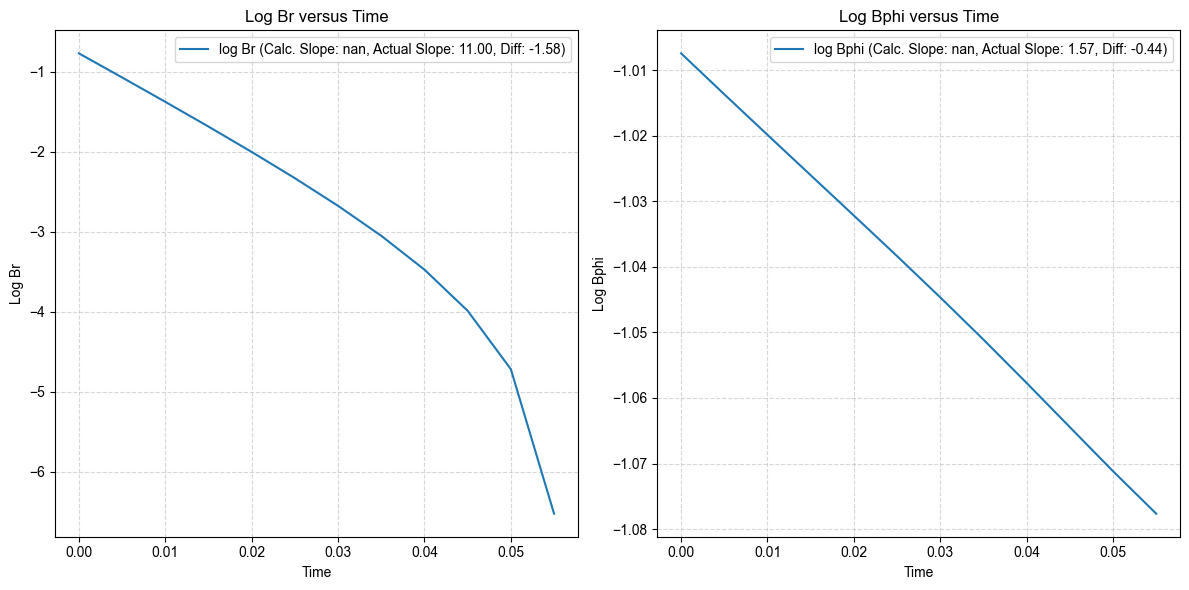

In [25]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(time[:12], log_Br, label=f'log Br (Calc. Slope: {np.sqrt(slope_Br):.2f}, Actual Slope: {actual_slope_Br:.2f}, Diff: {difference_Br:.2f})')
plt.xlabel('Time')
plt.ylabel('Log Br')
plt.title('Log Br versus Time')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time[:12], log_Bphi, label=f'log Bphi (Calc. Slope: {np.sqrt(slope_Bphi):.2f}, Actual Slope: {actual_slope_Bphi:.2f}, Diff: {difference_Bphi:.2f})')
plt.xlabel('Time')
plt.ylabel('Log Bphi')
plt.title('Log Bphi versus Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("results/log_Br_Bphi_vs_time_below_critical_D.png")
plt.show()